<h1 align="center">Designing an Artificial Neural Network for Predicting the Remaining Strength
of Metal Pipes Repaired with Composite Materials</h1>


In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import layers, models, optimizers, callbacks
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

<p>read data file</p>

In [2]:
df = pd.read_csv('data/70 Models.csv')
print("shape of data frame : ", df.shape)
print("\nsample datas")
df.head()

shape of data frame :  (70, 30)

sample datas


,2a,b,t,theta,l_(over+a),l_taper,K_1(0),K_1(90),K_1(180),e_l(Node1),...,e_r(Node4),e_l(Node5),e_theta(Node5),e_r(Node5),e_l(Node6),e_theta(Node6),e_r(Node6),e_l(Node7),e_theta(Node7),e_r(Node7)
0,8,5.603442,2.008066,0,45.019940,0.527170,13.478720,15.838258,13.119183,96.226133,...,-264.377025,94.877620,410.944369,-287.393028,114.554638,411.224499,-306.948359,118.725246,446.603194,-198.767276
1,8,4.430125,4.049539,0,51.016953,1.784573,11.519331,13.557389,11.481272,93.757110,...,-276.478194,103.969116,557.186629,-202.738786,72.783765,528.833955,-313.624897,80.503392,474.003444,-230.047347
2,8,2.700043,7.175884,0,22.102297,10.846831,8.572092,10.124508,9.019676,70.404811,...,-252.979659,44.700334,350.871331,-213.324660,80.427590,513.937760,-194.878010,78.082379,368.580612,-274.677007
3,8,4.670732,2.413889,0,55.907977,12.338342,12.529641,14.755326,12.303957,112.339814,...,-187.194151,117.693648,382.106156,-202.138713,103.256970,422.881601,-193.601806,91.222624,461.095974,-226.859199
4,8,3.578801,7.082839,0,51.973936,10.962590,9.321621,10.971217,9.672025,84.912742,...,-186.124753,91.203925,335.743885,-165.524601,40.125374,356.117874,-257.691559,55.320233,420.983482,-159.423830


<p align='right'>جدا سازی ورودی ها و خروجی ها</p>

In [3]:
input_features = df.columns[:6].tolist()
output_features = df.columns[6:].tolist()
df[input_features].describe()

,2a,b,t,theta,l_(over+a),l_taper
count,70.000000,70.000000,70.000000,70.0,70.000000,70.000000
mean,8.857143,3.864811,4.618630,0.0,40.514421,20.218120
std,1.467382,1.037443,2.564113,0.0,17.710434,11.801545
min,8.000000,2.110129,0.011104,0.0,4.228811,0.527170
25%,8.000000,2.937373,2.339724,0.0,25.989590,11.673841
50%,8.000000,3.790875,4.981816,0.0,42.714310,18.049422
75%,10.000000,4.667713,6.784719,0.0,54.799426,26.226632
max,12.000000,5.635224,8.751026,0.0,69.610892,43.991347


<p>نمودار های توزیع داده ها ورودی</p>

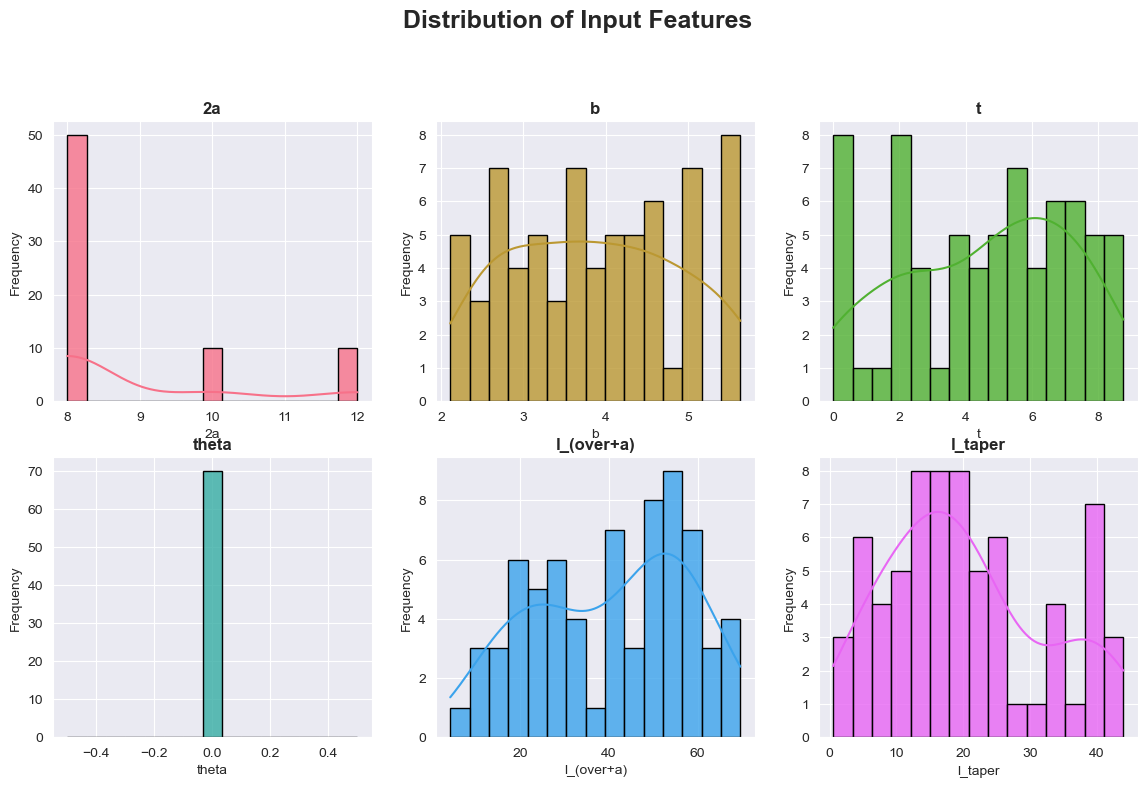

In [4]:
palette = sns.color_palette("husl", len(input_features))

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Distribution of Input Features', fontsize=18, fontweight='bold', y=1.02)

for i, feature in enumerate(input_features):
    row = i // 3
    col = i % 3
    sns.histplot(
        data=df,
        x=feature,
        bins=15,
        kde=True,
        color=palette[i],
        edgecolor='black',
        alpha=0.8,
        ax=axes[row, col]
    )
    axes[row, col].set_title(f'{feature}', fontweight='bold', fontsize=12)
    axes[row, col].set_ylabel('Frequency')


correlation matrix

Text(0.5, 1.0, 'Correlation Matrix of Input Features')

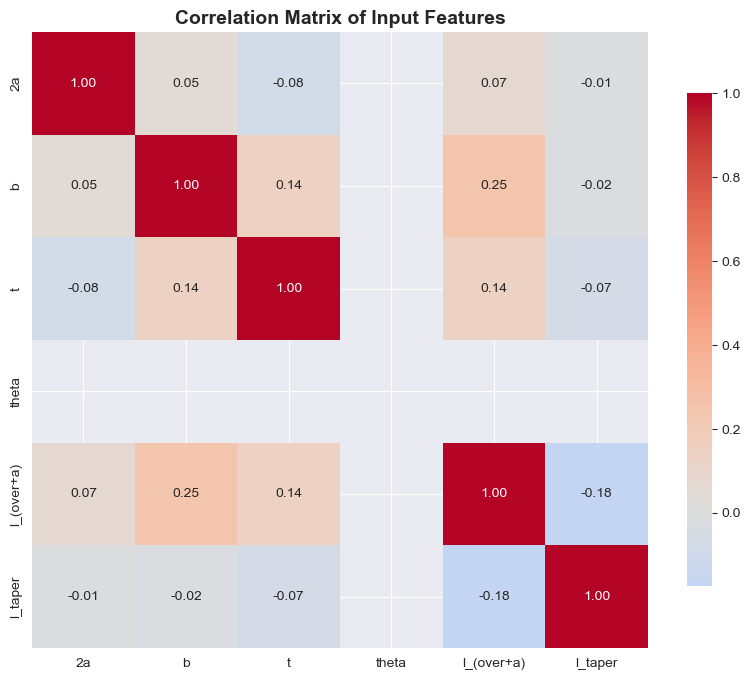

In [5]:
plt.figure(figsize=(10, 8))
correlation_matrix = df[input_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Input Features', fontsize=14, fontweight='bold')

box plot

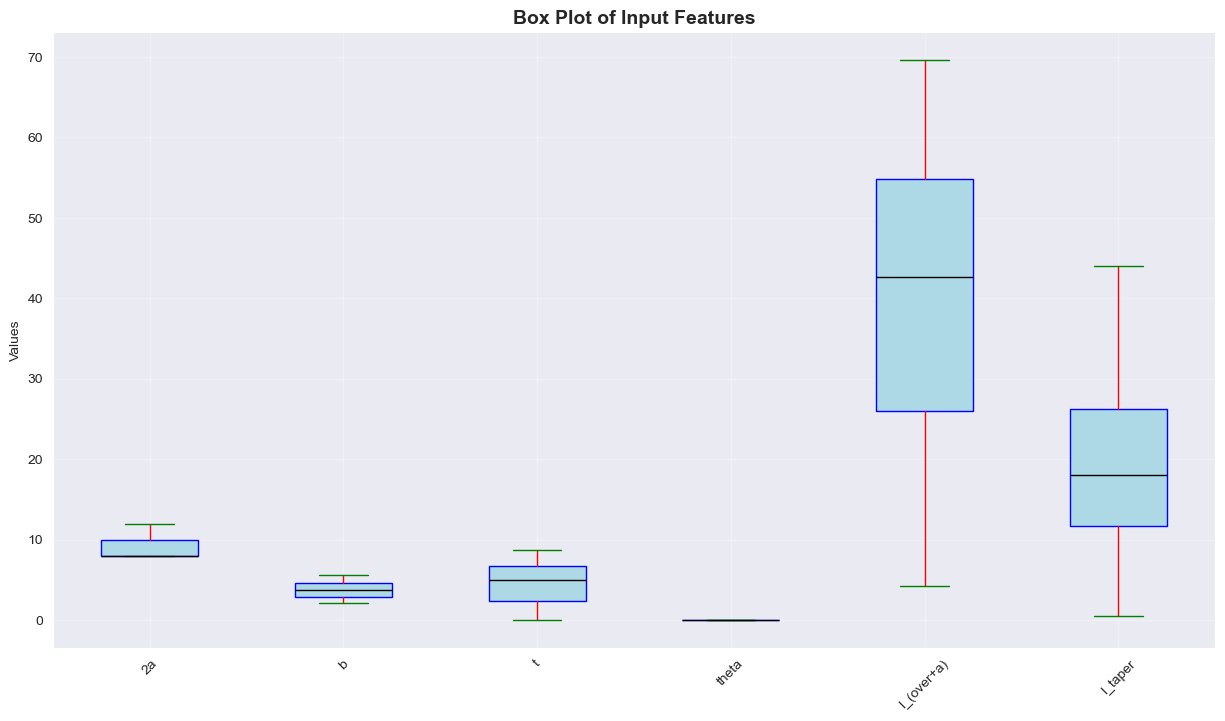

In [6]:
plt.figure(figsize=(15, 8))
df[input_features].boxplot(
    ax=plt.gca(),
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    whiskerprops=dict(color='red'),
    capprops=dict(color='green'),
    medianprops=dict(color='black'),
    flierprops=dict(markerfacecolor='orange', marker='o', markersize=5, linestyle='none'))
plt.title('Box Plot of Input Features', fontsize=14, fontweight='bold')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

preprocessing data

In [7]:
X = df[input_features].values
y = df[output_features].values

print("shape of inputs : ", X.shape)
print("shap of outputs : ", y.shape)


shape of inputs :  (70, 6)
shap of outputs :  (70, 24)


<h3>نرمال سازی داده ها</h3>


In [8]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

print("\nاطلاعات نرمال‌سازی ورودی‌ها:")
print("میانگین:", scaler_X.mean_)
print("انحراف معیار:", scaler_X.scale_)

print("\nنمونه‌ای از داده‌های نرمال‌شده:")
print("X_scaled[0:3]:")
print(X_scaled[:3])
print("y_scaled[0:3]:")
print(y_scaled[:3])


اطلاعات نرمال‌سازی ورودی‌ها:
میانگین: [ 8.85714286  3.86481084  4.61863007  0.         40.51442072 20.21811975]
انحراف معیار: [ 1.45686272  1.03000583  2.54573238  1.         17.58347586 11.71694538]

نمونه‌ای از داده‌های نرمال‌شده:
X_scaled[0:3]:
[[-0.58834841  1.68798168 -1.02546671  0.          0.25623599 -1.68055319]
 [-0.58834841  0.54884581 -0.223547    0.          0.59729557 -1.57323825]
 [-0.58834841 -1.13083637  1.00452596  0.         -1.04712651 -0.79980649]]
y_scaled[0:3]:
[[ 1.90380704  1.87248213  1.94525365  0.77357886  1.4320893  -0.39568228
   1.79391304  0.81674638 -0.14534981  1.19529522  1.50115475 -1.90502225
   1.86618666  0.09431501 -0.68196437  0.80370681 -0.70780544 -1.20576778
   1.68662725 -0.76094004 -1.36711361  1.86709449 -0.0347222   0.79654093]
 [ 0.5202604   0.50846389  0.53624194  0.65244502  0.12980049  1.10694107
   0.96787859  1.32660417 -1.26905178  1.02424186 -0.01531746 -0.59137266
   0.10472686  0.44242182 -0.93220812  1.19767812  1.48237941  0.

<p>تقسیم بندی داده ها به سه قسمت train, test, validation</p>

In [9]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled,
    y_scaled,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

<p>ساخت مدل</p>

In [10]:
def create_neural_network(input_dim, output_dim):
    model = models.Sequential([
    # لایه ورودی
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # لایه های مخفی
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    # لایه خروجی
    layers.Dense(output_dim, activation='linear'),

    ])
    return model


# ایجاد مدل
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

model = create_neural_network(input_dim, output_dim)

# کامپایل کردن مدل
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,064 (340.09 KB)

 Trainable params: 85,784 (335.09 KB)

 Non-trainable params: 1,280 (5.00 KB)

<p>آموزش دادن مدل</p>

In [11]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=20,
    min_lr= 1e-7
)

# آموزش مدل
print("--------------start training-------------")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("--------------end of training----------------")

--------------start training-------------
Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 2.8488 - mae: 1.3377 - val_loss: 1.1326 - val_mae: 0.8967 - learning_rate: 0.0010
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.6125 - mae: 1.2773 - val_loss: 1.1329 - val_mae: 0.8955 - learning_rate: 0.0010
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5632 - mae: 1.2829 - val_loss: 1.1299 - val_mae: 0.8920 - learning_rate: 0.0010
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5151 - mae: 1.2947 - val_loss: 1.1294 - val_mae: 0.8904 - learning_rate: 0.0010
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3620 - mae: 1.2180 - val_loss: 1.1274 - val_mae: 0.8890 - learning_rate: 0.0010
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2502 - mae: 1.2072 - val_loss: 1.1270 - val_mae: 0.8883 - learning_rate: 0.0010
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2451 - mae: 1.1941 - val_loss: 1.1283 - val_mae: 0.8882 - le

<p>ارزیابی عملکرد مدل</p>

In [12]:
y_pred_scaled = model.predict(X_test, verbose=1)

y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)
print("------------end of prediction-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
------------end of prediction-------------


<p>نمایش و مقایسه سه نمونه اول مقدار پیش بینی شده با مقدار واقعی</p>

In [13]:
print("\n3 نمونه اول:")
for i in range(min(3, len(y_test_original))):
    print(f"نمونه {i+1}:")
    print(f"  واقعی: {y_test_original[i][:5]}")  # 5 مقدار اول
    print(f"  پیش‌بینی: {y_pred[i][:5]}")


3 نمونه اول:
نمونه 1:
  واقعی: [ 10.61860379  12.4042111   10.83299648  76.0489299  333.3661444 ]
  پیش‌بینی: [ 10.472793  11.925565  10.384587  65.65104  402.44684 ]
نمونه 2:
  واقعی: [ 10.99070713  12.96915382  11.01226044  64.70803527 496.2544917 ]
  پیش‌بینی: [ 10.826566  12.446758  10.744466  80.698296 430.44244 ]
نمونه 3:
  واقعی: [  9.41317297  11.14076486   9.68558108  98.8441459  512.9811991 ]
  پیش‌بینی: [ 10.044718  12.731188  10.648263  77.85815  440.4274  ]


<p>محاسبه معیارهای دقت برای هر پارامتر خروجی</p>

In [14]:
accuracy_metrics = []

for i, param_name in enumerate(output_features):
    # R² Score
    r2 = r2_score(y_test_original[:, i], y_pred[:, i])
    # Mean Squared Error
    mse = mean_squared_error(y_test_original[:, i], y_pred[:, i])
    # Mean Absolute Error
    mae = mean_absolute_error(y_test_original[:, i], y_pred[:, i])

    # Accuracy percentage (based on relative error)
    relative_errors = np.abs((y_test_original[:, i] - y_pred[:, i]) / (y_test_original[:, i] + 1e-8))
    accuracy_percent = (1 - np.mean(relative_errors)) * 100

    accuracy_metrics.append({
        'Parameter': param_name,
        'R²_Score': r2,
        'MSE': mse,
        'MAE': mae,
        'Accuracy_Percent': max(0, accuracy_percent)
    })

accuracy_df = pd.DataFrame(accuracy_metrics)

print("نتایج دقت پیش‌بینی برای هر پارامتر خروجی:")
print("="*80)
for i, row in accuracy_df.iterrows():
    print(f"پارامتر: {row['Parameter']}")
    print(f"  R² Score: {row['R²_Score']:.4f}")
    print(f"  MSE: {row['MSE']:.4f}")
    print(f"  MAE: {row['MAE']:.4f}")
    print(f"  دقت تقریبی: {row['Accuracy_Percent']:.2f}%")
    print("-"*50)

نتایج دقت پیش‌بینی برای هر پارامتر خروجی:
پارامتر: K_1(0)
  R² Score: 0.7066
  MSE: 0.2552
  MAE: 0.4150
  دقت تقریبی: 95.71%
--------------------------------------------------
پارامتر: K_1(90)
  R² Score: 0.4905
  MSE: 0.6086
  MAE: 0.6428
  دقت تقریبی: 94.42%
--------------------------------------------------
پارامتر: K_1(180)
  R² Score: 0.4365
  MSE: 0.3399
  MAE: 0.5026
  دقت تقریبی: 94.96%
--------------------------------------------------
پارامتر: e_l(Node1)
  R² Score: 0.3313
  MSE: 292.9675
  MAE: 15.1548
  دقت تقریبی: 81.22%
--------------------------------------------------
پارامتر: e_theta(Node1)
  R² Score: -0.1024
  MSE: 5027.9557
  MAE: 69.2825
  دقت تقریبی: 85.49%
--------------------------------------------------
پارامتر: e_r(Node1)
  R² Score: 0.5684
  MSE: 649.6086
  MAE: 21.2506
  دقت تقریبی: 90.85%
--------------------------------------------------
پارامتر: e_l(Node2)
  R² Score: 0.1852
  MSE: 282.8922
  MAE: 14.6142
  دقت تقریبی: 79.81%
---------------------------

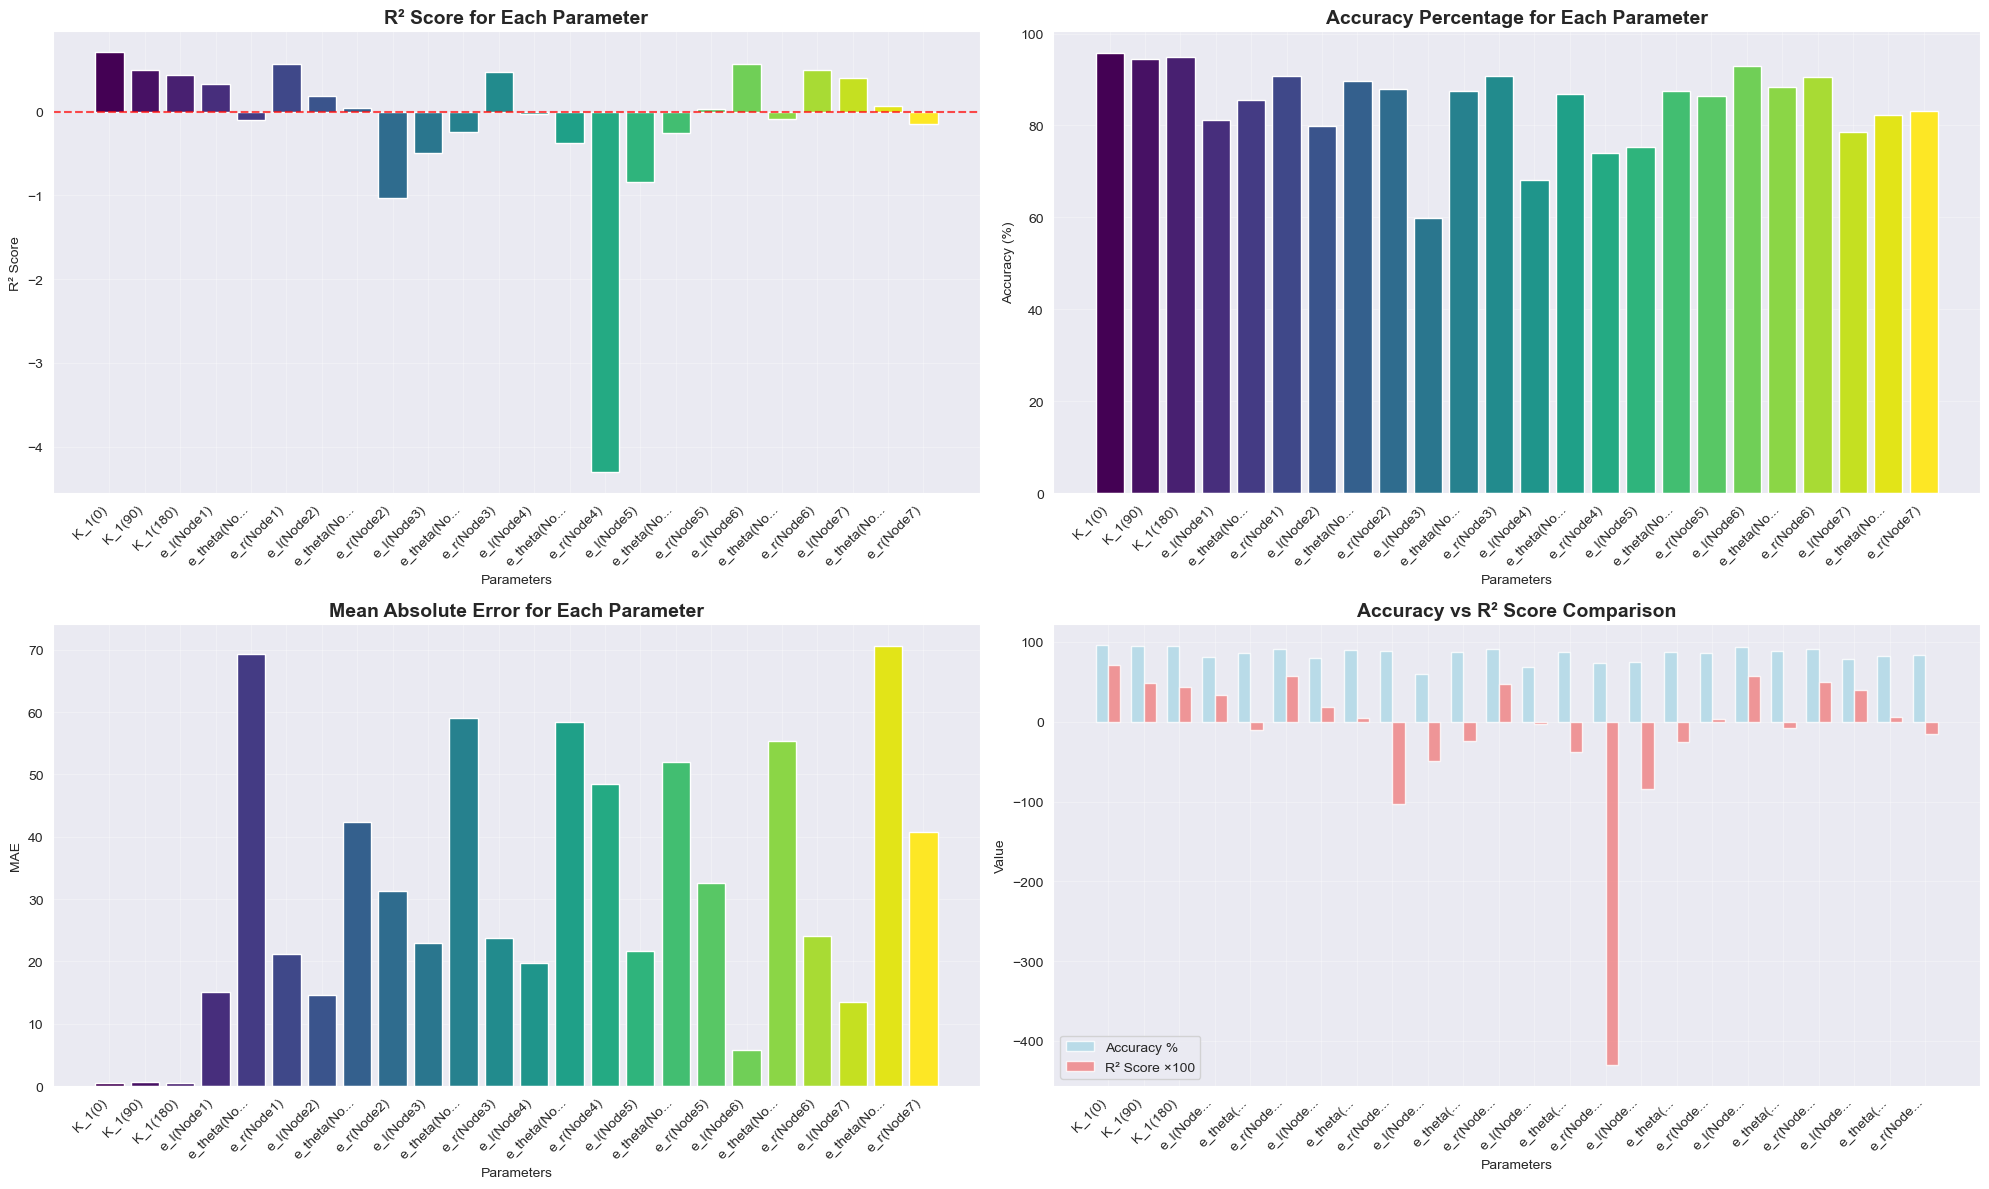


خلاصه آماری کلی مدل:
میانگین دقت کلی: 84.69%
بهترین دقت: 95.71% (K_1(0))
کمترین دقت: 59.86% (e_l(Node3))
میانگین R² Score: -0.1299
تعداد پارامترهای با دقت بالای 90%: 7
تعداد پارامترهای با R² > 0.5: 3


In [15]:
# نمودار مقایسه دقت پارامترها
plt.figure(figsize=(20, 12))

# نمودار 1: R² Score
plt.subplot(2, 2, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(accuracy_df)))
bars1 = plt.bar(range(len(accuracy_df)), accuracy_df['R²_Score'], color=colors)
plt.title('R² Score for Each Parameter', fontsize=14, fontweight='bold')
plt.xlabel('Parameters')
plt.ylabel('R² Score')
plt.xticks(range(len(accuracy_df)), [name[:10] + '...' if len(name) > 10 else name for name in accuracy_df['Parameter']],
           rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# نمودار 2: دقت درصدی
plt.subplot(2, 2, 2)
bars2 = plt.bar(range(len(accuracy_df)), accuracy_df['Accuracy_Percent'], color=colors)
plt.title('Accuracy Percentage for Each Parameter', fontsize=14, fontweight='bold')
plt.xlabel('Parameters')
plt.ylabel('Accuracy (%)')
plt.xticks(range(len(accuracy_df)), [name[:10] + '...' if len(name) > 10 else name for name in accuracy_df['Parameter']],
           rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# نمودار 3: Mean Absolute Error
plt.subplot(2, 2, 3)
bars3 = plt.bar(range(len(accuracy_df)), accuracy_df['MAE'], color=colors)
plt.title('Mean Absolute Error for Each Parameter', fontsize=14, fontweight='bold')
plt.xlabel('Parameters')
plt.ylabel('MAE')
plt.xticks(range(len(accuracy_df)), [name[:10] + '...' if len(name) > 10 else name for name in accuracy_df['Parameter']],
           rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# نمودار 4: مقایسه کلی (دقت و R²)
plt.subplot(2, 2, 4)
x_pos = np.arange(len(accuracy_df))
width = 0.35

bars4 = plt.bar(x_pos - width/2, accuracy_df['Accuracy_Percent'], width, label='Accuracy %', alpha=0.8, color='lightblue')
bars5 = plt.bar(x_pos + width/2, accuracy_df['R²_Score']*100, width, label='R² Score ×100', alpha=0.8, color='lightcoral')

plt.title('Accuracy vs R² Score Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Parameters')
plt.ylabel('Value')
plt.xticks(x_pos, [name[:8] + '...' if len(name) > 8 else name for name in accuracy_df['Parameter']],
           rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# خلاصه آماری کلی
print("\nخلاصه آماری کلی مدل:")
print("="*50)
print(f"میانگین دقت کلی: {accuracy_df['Accuracy_Percent'].mean():.2f}%")
print(f"بهترین دقت: {accuracy_df['Accuracy_Percent'].max():.2f}% ({accuracy_df.loc[accuracy_df['Accuracy_Percent'].idxmax(), 'Parameter']})")
print(f"کمترین دقت: {accuracy_df['Accuracy_Percent'].min():.2f}% ({accuracy_df.loc[accuracy_df['Accuracy_Percent'].idxmin(), 'Parameter']})")
print(f"میانگین R² Score: {accuracy_df['R²_Score'].mean():.4f}")
print(f"تعداد پارامترهای با دقت بالای 90%: {(accuracy_df['Accuracy_Percent'] > 90).sum()}")
print(f"تعداد پارامترهای با R² > 0.5: {(accuracy_df['R²_Score'] > 0.5).sum()}")